In [563]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import itertools

pd.options.mode.chained_assignment = None  # default='warn'

In [564]:
Racesdf = pd.read_csv('Datasets/races.csv', sep=',')
Racesdf.sort_values(by="date", inplace=True)
Racesdf = Racesdf.loc[Racesdf["year"]<2024]
Racesdf["race"] = Racesdf["year"].astype(str) + " " + Racesdf["name"]
Racesdf = Racesdf[["raceId", "year", "round", "race"]]

Driversdf = pd.read_csv('Datasets/drivers.csv', sep=',')
Driversdf["name"] =Driversdf["forename"] + " " + Driversdf["surname"]
Driversdf = Driversdf[["driverId", "name"]]


Resultsdf = pd.read_csv('Datasets/results.csv', sep=',')
Resultsdf = Resultsdf[["resultId", "raceId", "driverId", "position", "positionOrder"]]
Resultsdf = Resultsdf.replace(r"\\N", "DNF" , regex=True)
nameMap = Driversdf.set_index("driverId")["name"]
Resultsdf["driverName"] = Resultsdf["driverId"].map(nameMap)


In [565]:
InitialElo = 1300
kValue = 5
Drivers = {}
Races ={}

In [566]:
def RacePositions(RaceID, include = "all"):
    if include == "all":
        Positions = Resultsdf.loc[Resultsdf["raceId"]== RaceID, ["positionOrder", "driverName", "raceId"]]
        Positions["position"] = Positions["positionOrder"]
    elif include == "finished":
        Positions = Resultsdf.loc[Resultsdf["raceId"]== RaceID, ["position", "driverName", "raceId"]]
        Positions = Positions.loc[Positions["position"] != "DNF"]
        Positions["position"] = Positions["position"].astype(int)
    else:
        raise ValueError("include= all or finished")
    
    Positions.sort_values(by="position", inplace=True)
    Positions['nDrivers'] = Positions.groupby('position')['position'].transform('count')
    return Positions[["position", "driverName", "nDrivers"]]

def EloChange(Elo1, Elo2, Result="Win", nDrivers1=1, nDrivers2=1):
    K = kValue/nDrivers1/nDrivers2
    P1 = (1/(1+10**((Elo2-Elo1)/400)))
    P2 = (1/(1+10**((Elo1-Elo2)/400)))
    if Result == "Win":
        NewElo1 = K*(1.0 - P1)
        NewElo2 = K*(0.0 - P2)
    elif Result == "Draw":
        NewElo1 = K*(0.5 - P1)
        NewElo2 = K*(0.5 - P2)
    elif Result == "Loss":
        NewElo1 = K*(0.0 - P1)
        NewElo2 = K*(1.0 - P2)
    else:
        raise ValueError("EloChange result must be Win, Draw or Loss")
    return NewElo1, NewElo2

def AddDriver(DriverName):
    Drivers[DriverName] = {}
    Drivers[DriverName]["Races"] = 0
    Drivers[DriverName]["Wins"]= 0
    Drivers[DriverName]["Elo"]= InitialElo
    Drivers[DriverName]["Max Elo"]= 1000.0
    Drivers[DriverName]["Max Elo Race"]= 0
    Drivers[DriverName]["Min Elo"]= 2000.0
    Drivers[DriverName]["Min Elo Race"]= 0
    return

In [567]:
def RaceCalculator(RaceId, positions):
    raceName = list(Racesdf.loc[Racesdf["raceId"]==RaceId, "race"])[0]
    Races[raceName] = {}
    ResultDict = dict(zip(positions.driverName, positions.position))
    nDriverDict = dict(zip(positions.driverName, positions.nDrivers))
    Changes = {}
    

    for driver in ResultDict.keys():
        if driver not in Drivers:
            AddDriver(driver)
            Drivers[driver]["First Race"] = raceName
        Changes[driver] = 0
        Drivers[driver]["Last Race"] = raceName
     
    for driver1, driver2 in itertools.combinations(ResultDict.keys(), 2):
        if ResultDict[driver1] < ResultDict[driver2]:
            a = "Win"
        elif ResultDict[driver1] == ResultDict[driver2]:
            a = "Draw"
        elif ResultDict[driver1] > ResultDict[driver2]:
            a = "Loss"
        else: 
            raise ValueError("Something Happened")
        change1, change2 = EloChange(Drivers[driver1]["Elo"], Drivers[driver2]["Elo"], a, nDrivers1=nDriverDict[driver1],nDrivers2=nDriverDict[driver2])
        Changes[driver1] += change1
        Changes[driver2] += change2

    for driver in ResultDict.keys():
        Drivers[driver]["Races"] += 1
        if ResultDict[driver] == 1:
            Drivers[driver]["Wins"] += 1
        Drivers[driver]["Elo"] += Changes[driver]
        if Drivers[driver]["Elo"] >= Drivers[driver]["Max Elo"]:
            Drivers[driver]["Max Elo"] = Drivers[driver]["Elo"]
            Drivers[driver]["Max Elo Race"] = raceName
        if Drivers[driver]["Elo"] <= Drivers[driver]["Min Elo"]:
            Drivers[driver]["Min Elo"] = Drivers[driver]["Elo"]
            Drivers[driver]["Min Elo Race"] = raceName
        Races[raceName][driver] = Drivers[driver]["Elo"]
    
    return


In [568]:
def DriverChecker(DriverList):
    df = pd.DataFrame.from_dict(DriverList, orient="index")
    return df
def RacesChecker(RacesList):
    df = pd.DataFrame.from_dict(RacesList).T
    return df

In [569]:
def AllTimeCalculator(include="all"):
    Drivers.clear()
    Races.clear()
    
    for ind in Racesdf.index:
        a = Racesdf["raceId"][ind]
        RaceCalculator(a, RacePositions(a, include))

    
    return Drivers, Races

def SeasonCalculator(Year, include="all"):
    Drivers.clear()
    Races.clear()
    SeasonRacesdf = Racesdf.loc[Racesdf["year"]==Year]
    for index, row in SeasonRacesdf.iterrows():
        a = row["raceId"]
        RaceCalculator(a, RacePositions(a, include))
    
    return Drivers, Races

In [570]:
def resultsGraph(RacesDFrame, DriversDFrame, showTop=5, sortBy="Max Elo"):
    Drivers = DriversDFrame.sort_values(sortBy, ascending=False).head(showTop).index
    RaceData =RacesDFrame[Drivers]
    fig, ax = plt.subplots()
    ax.plot(RaceData, linewidth = '.5')
    ax.set_yticks(np.arange(800, 2400, step=200))
    ax.set_xticks([])
    ax.legend(Drivers, ncol=2)
    return fig

In [571]:
#SeasonCalculator(1951, include="finished")
#c = DriverChecker(Drivers)
#d = RacesChecker(Races)


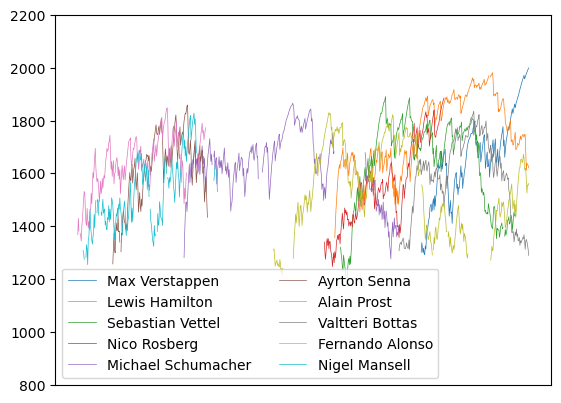

In [572]:
AllTimeCalculator(include="all")
a = DriverChecker(Drivers)
b = RacesChecker(Races)
AllTimeTop10EloAll = resultsGraph(b, a, showTop=10)
AllTimeTop10EloAll.savefig("Presentation/AllTimeTop10EloAll.png")

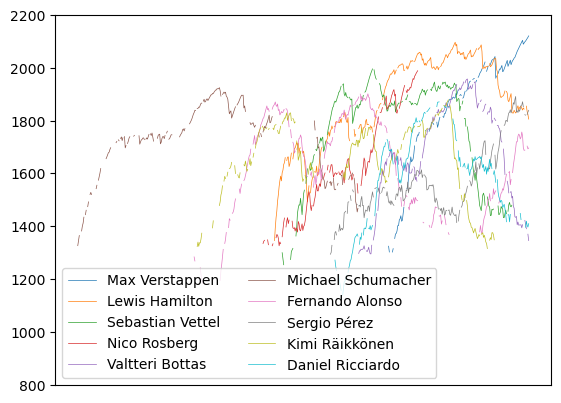

In [573]:
AllTimeCalculator(include="finished")
a = DriverChecker(Drivers)
b = RacesChecker(Races)
AllTimeTop10EloFinished = resultsGraph(b, a, showTop=10)
AllTimeTop10EloFinished.savefig("Presentation/AllTimeTop10EloFinished.png")